In [156]:
import csv
import numpy as np
import LogisticRegression
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.optimize import minimize
from sklearn import svm
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve
from sklearn.lda import LDA
%matplotlib inline

In [157]:
record = csv.reader(open('/Users/dekedor/Downloads/train.csv', 'r'), delimiter = ',')
data_array = []
for row in record:
    data_array.append(row)
data_array = np.array(data_array)

In [158]:
data = {}
index = 0
for field in data_array[0][:]:
    data[field] = []
    data[field] = data_array[1:, index]
    index = index + 1

In [159]:
features = {}
features['Age'] = np.array([x if x < 1000 else -1 for x in data['Age']], dtype = int)
features['hasAge'] = np.array([1 if x < 1000 else 0 for x in data['Age']], dtype = int)
features['hasCabin'] = np.array([1 if len(x) > 0 else 0 for x in data['Cabin']], dtype = int)
features['Cherbourg'] = np.array([1 if x == 'C' else 0 for x in data['Embarked']], dtype = int)
features['Queenstown'] = np.array([1 if x == 'Q' else 0 for x in data['Embarked']], dtype = int)
features['Southampton'] = np.array([1 if x == 'S' else 0 for x in data['Embarked']], dtype = int)
features['Fare'] = np.array(data['Fare'], dtype=float)
features['ParentsChildren'] = np.array(data['Parch'], dtype=int)
features['SiblingsSpouses'] = np.array(data['SibSp'], dtype=int)
features['isMale'] = np.array([1 if x == 'male' else 0 for x in data['Sex']], dtype = int)
features['isFemale'] = np.array([1 if x == 'female' else 0 for x in data['Sex']], dtype = int)
features['isUpper'] = np.array([1 if x == '1' else 0 for x in data['Pclass']], dtype = int)
features['isMiddle'] = np.array([1 if x == '2' else 0 for x in data['Pclass']], dtype = int)
features['isLower'] = np.array([1 if x == '3' else 0 for x in data['Pclass']], dtype = int)

In [160]:
result = np.array(data['Survived'], dtype = int)

In [161]:
input = np.array([np.ones(np.shape(features['isMale'])), features['isMale']])
#input = np.array([np.ones(np.shape(features['isMale'])), features['isMale'], features['hasCabin'],\
#                  features['Southampton'], features['Cherbourg'], features['Queenstown'], features['isUpper'],\
#                  features['isMiddle'], features['isLower'], features['hasCabin']])
m = np.shape(input)

In [162]:
for i in range(m[0]):
    if i > 0:
        mu = np.mean(input[i])
        sigma = np.std(input[i])
        input[i] = (input[i] - mu)/ sigma

In [163]:
theta = np.random.rand(m[0])*.1 - .05
alpha = .01
num_iter = 3
cost_array = np.zeros(num_iter)
for i in range(num_iter):
    for j in range(len(theta)):
        for k in range(m[1]):
            theta[j] = theta[j] - (alpha / m[1]) *\
            (LogisticRegression.sigmoid(np.sum(input[:, k] * theta)) - result[k]) * input[j][k]
    cost_array[i] = LogisticRegression.costFunction(input, theta, result)

[-0.00324743 -0.04463628]


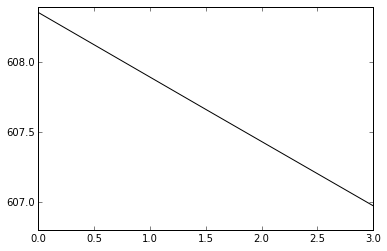

In [164]:
learning = plt.figure()
plt.plot(np.linspace(0, num_iter, num = num_iter), cost_array, 'k-')
print(theta)

In [165]:
def f_der(input, theta, result):
    grad = np.zeros(len(theta))
    for j in range(len(theta)):
        for k in range(m[1]):
            grad[j] = grad[j] + (1 / m[1]) *\
            (LogisticRegression.sigmoid(np.sum(input[:, k] * theta)) - result[k]) * input[j][k]
            
der = lambda x: f_der(input, x, result)

In [166]:
f = lambda x: LogisticRegression.costFunction(input, x, result)
theta0 = np.random.rand(m[0])*.1 - .05
res = minimize(f, theta0, method='nelder-mead', options={'xtol': 1e-8, 'disp': True, 'maxfev' : 10000})
theta = res['x']

Optimization terminated successfully.
         Current function value: 458.901962
         Iterations: 85
         Function evaluations: 166


In [167]:
correct = 0
for i in range(m[1]):
    if LogisticRegression.sigmoid(np.sum(input[:, i] * theta)) > .5 and result[i] == 1:
        correct = correct + 1
    elif LogisticRegression.sigmoid(np.sum(input[:, i] * theta)) < .5 and result[i] == 0:
        correct = correct + 1
        
print(float(correct)/float(m[1]))

0.786756453423


In [168]:
clf = svm.SVC(C=.00001, kernel = 'rbf', gamma = 1.0)
svm_input = np.reshape(input, (m[1], m[0]))
clf.fit(svm_input, result)

SVC(C=1e-05, cache_size=200, class_weight=None, coef0=0.0, degree=3,
  gamma=1.0, kernel='rbf', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)

In [169]:
correct = 0
for i in range(m[1]):
    if clf.predict(input[:, i]) == result[i]:
        correct = correct + 1
        
print(float(correct)/float(m[1]))

0.616161616162


In [170]:
lr = LR(C = 10000)
lr.fit(svm_input, result)

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [171]:
correct = 0
for i in range(m[1]):
    if lr.predict(input[:, i]) == result[i]:
        correct = correct + 1
        
print(float(correct)/float(m[1]))

0.616161616162


In [172]:
lda_fit = LDA(shrinkage='auto', solver='eigen')
lda_fit.fit(svm_input, result)

LDA(n_components=None, priors=None, shrinkage='auto', solver='eigen',
  store_covariance=False, tol=0.0001)

In [173]:
correct = 0
for i in range(m[1]):
    if lda_fit.predict(input[:, i]) == result[i]:
        correct = correct + 1
        
print(float(correct)/float(m[1]))

0.616161616162


In [175]:
num_men = np.sum(features['isMale'])
num_women = np.sum(features['isFemale'])
num_men_suvived = np.sum(features['isMale']*result)
num_women_suvived = np.sum(features['isFemale']*result)
print(num_men, num_men_suvived, float(num_men_suvived)/num_men)
print(num_women, num_women_suvived, float(num_women_suvived)/num_women)

(577, 109, 0.18890814558058924)
(314, 233, 0.7420382165605095)
